# Modelos de aprendizaje supervisado: Bank Marketing

El objetivo del proyecto será ajustar una serie de modelos de aprendizaje supervisado para posteriormente seleccionar el mejor en alguna métrica en específico y poder mejorarlo teniendo en cuenta cierta particularidad del conjunto de datos.

El conjunto de datos sobre el cuál se trabajará consiste en una base de datos con información de una campaña de marketing de un banco. El objetivo será lograr ajustar un modelo que pueda pronosticar la contratación de un producto.

Para conocer mejor cada una de las variables dentro del conjunto de datos, se recomienda visitar el siguiente [enlace](https://archive.ics.uci.edu/dataset/222/bank+marketing), ahí mismo puede descargarse en formato csv.

Comenzamos por importar la base y los módulos básicos necesarios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')


from zipfile import ZipFile
from io import BytesIOhttps://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
import urllib.request as urllib2

r = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip").read()
file = ZipFile(BytesIO(r))
bank = file.open("bank.csv")
bank = pd.read_csv(bank,sep=";")

In [3]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Exploremos rápidamente la frecuencia de cada categoría para todas las variables nominales.

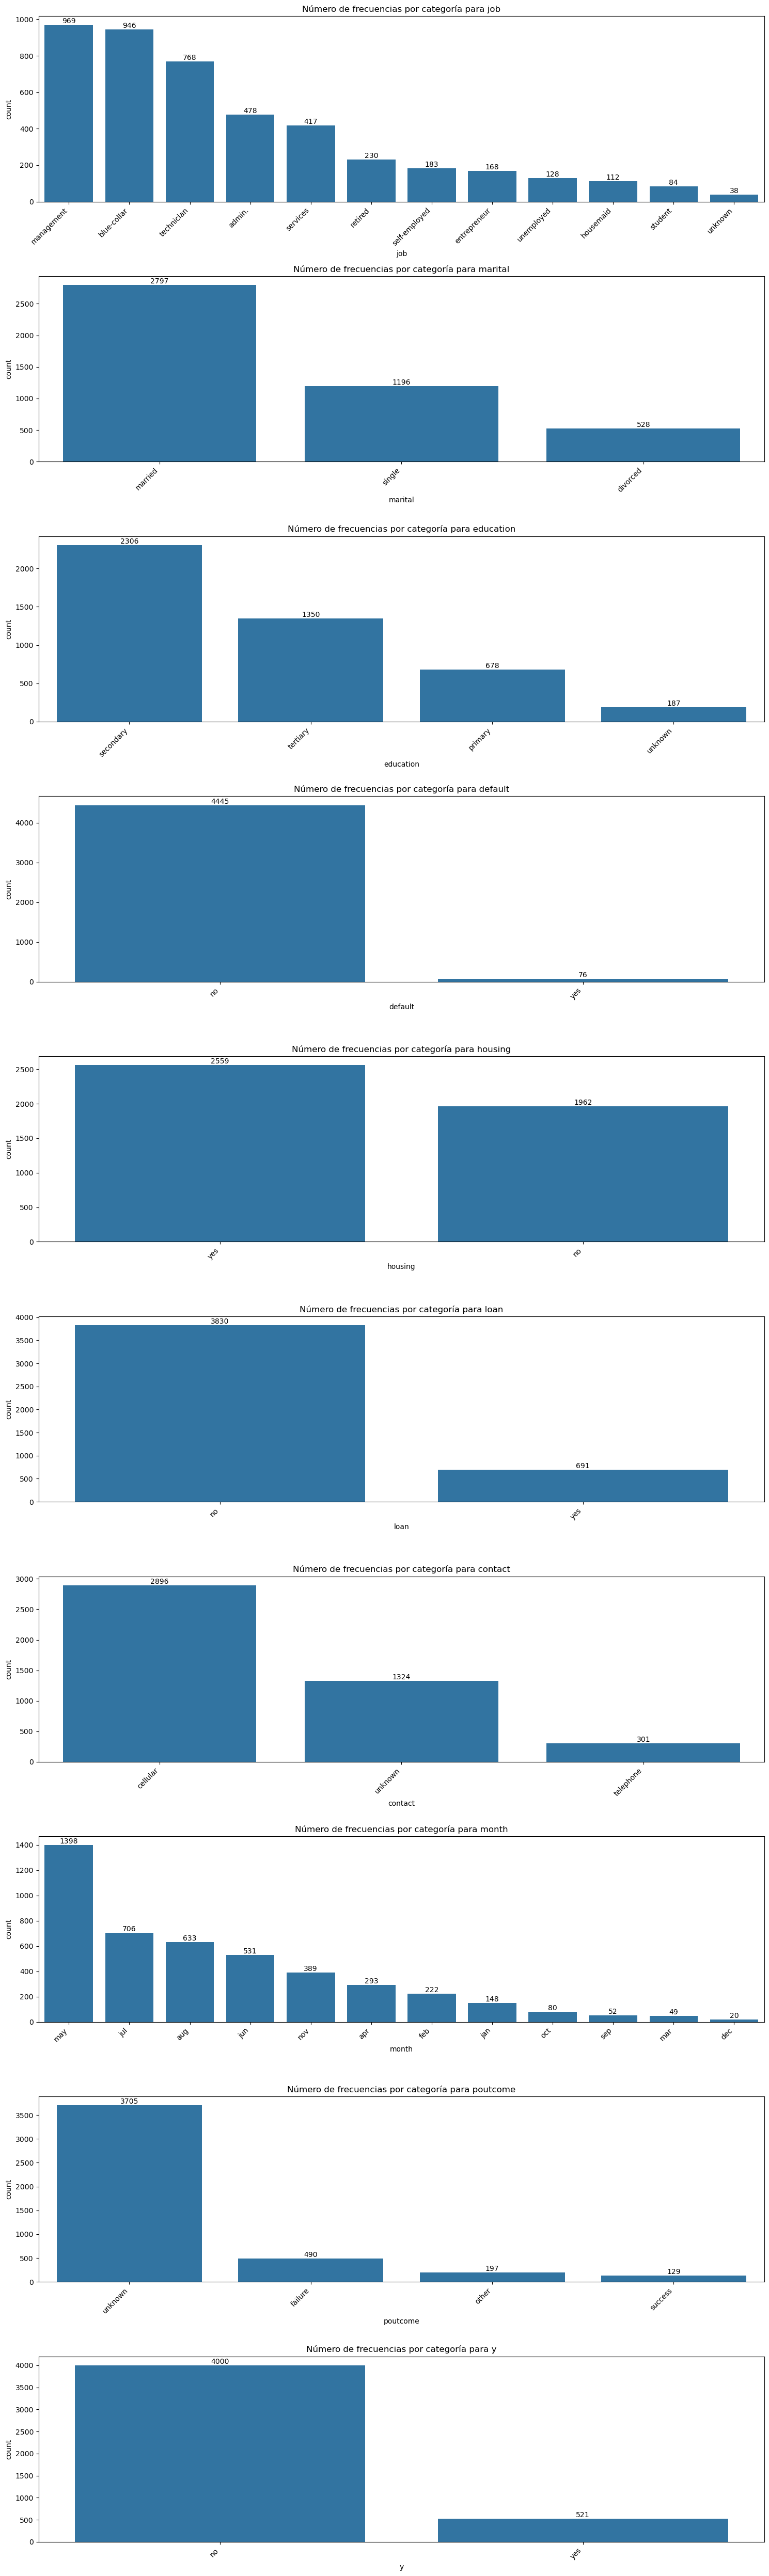

In [406]:
categorical_columns = bank.select_dtypes(include=['object']).columns
plt.figure(figsize=(15, 50))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    ax = sns.countplot(data= bank, x=col, order=bank[col].value_counts().index)
    plt.title(f'Número de frecuencias por categoría para {col}')
    plt.xticks(rotation=45, ha='right')
    
    for p in ax.containers:
        ax.bar_label(p)

plt.tight_layout()
plt.show()

Del vistazo rápido anterior podemos notar cosas interesantes por ejemplo:

1. Las 3 ocupaciones con mayor frecuencia son management(puestos gerenciales), blue-collar(oficinistas) y technician(técnicos). El número de frecuencias para las demás categorías disminuye considerablemente.

2. La mayoría de los clientes se encuentran casados.

3. La mayoría de los clientes tienen educación secundaria.

4. Una mayoría significativa de los clientes no tiene créditos en situación de impago (default = no) ni ha pedido préstamos (loan = no).

5. La mayoría de los clientes fueron contactados por última vez en el mes de mayo.

6. Se desconoce el resultado de la anterior campaña de marketing para la mayoría de los clientes.

7. Hay un claro desbalance en las clases de la variable respuesta: 4000 clientes que no dieron un depósito contra 521 que sí lo dieron. Esto puede provocar problemas de clasificación en los modelos y se abordará cómo resolver esta situación más adelante.

Ahora importaremos las funciones generales para el preprocesamiento de datos y funciones generales de aprendizaje estadístico.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

# Funciones de Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter

# Funciones de Machine Learning
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Antes de realizar el preprocesamiento de los datos, notamos 2 cosas:

1. Ya que la variable respuesta es una variable nominal con las etiquetas "Sí" (yes) y "No" (no), hay que convertirla a numérica. Para ello decidimos asignar el valor de 1 a las observaciones cuyo valor en la variable respuesta es yes y 0 para aquellas con valor no.

2. La variable duration tiene una clara correlación con la variable respuesta y además sólo se conoce después de conocer el valor de y, por lo que para hacer un análisis congruente se optó por eliminarla.


In [11]:
data = bank.copy()
data['y'] = data['y'].map({'no' : 0, 'yes' : 1})
X = data.drop(columns = ['duration',"y"])
Y = data["y"]

Una vez aclarado lo anterior, procedemos a separar las variables en numéricas y categóricas.

In [13]:
X.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [15]:
variables_num = X.select_dtypes(include=['float64', 'int64']).columns.values
variables_nom = X.select_dtypes(include=['object', 'bool']).columns.values

print(variables_num)
print(variables_nom)

['age' 'balance' 'day' 'campaign' 'pdays' 'previous']
['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome']


Crearemos una función auxiliar para convertir las variables categóricas a dummies mediante One Hot Encoding.

In [17]:
def dummify(ohe, x, columns):
    transformed_array = ohe.transform(x)

    enc = ohe.named_transformers_['cat'].named_steps['onehot']
    feature_lst = enc.get_feature_names_out(variables_nom.tolist())   
    
    cat_colnames = np.concatenate([feature_lst]).tolist()
    all_colnames = variables_num.tolist() + cat_colnames 
    
    df = pd.DataFrame(transformed_array, index = x.index, columns = all_colnames)
    
    return transformed_array, df

Utilizamos la función anterior para las variables categóricas y adicionalmente estandarizamos las variables numéricas puesto que estas se encuentran en escalas diferentes.

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, variables_num),
        ('cat', categorical_transformer, variables_nom)])

ohe = preprocessor.fit(X)

X_transformed = ohe.transform(X)

Finalmente tenemos los datos con los que trabajaremos justo en el formato que las necesitamos.

X_transformed_array, X_transformed = dummify(ohe, X, variables_nom)

X_transformed.head()

## Ajuste y Selección de Modelos

### Regresión Logística

Comenzamos por el ajuste del modelo de regresión logística. Antes de todo realizaremos la partición del conjunto de entrenamiento y prueba.

In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

Creamos un diccionario con una selección de parámetros a considerar y mediante GridSearch seleccionaremos la combinación que de como resultado el mejor modelo basado en los scores.

In [176]:
model_params = {
    "reg_log":{
    "model":LogisticRegression(), 
    "params":{
        "penalty":["l1","l2"], # Tipo de regularización L1 o L2 (Lasso o Ridge)
        "max_iter":[100,1000,10000], # Número de iteraciones en descenso de gradiente
        "C":[.0001,.001,.01,.1,1,10,100], # Parámetro de penalización (En esta implementación es el inverso de alfa)
        "solver":["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"] # Algoritmo de optimización
            }
              }
              }

In [29]:
start_time = time.time()
accuracy_models=[]
for model_name,mp in model_params.items():
    modelo = GridSearchCV(mp["model"], mp["params"], cv= 10, n_jobs = -1, scoring = "accuracy", verbose = 0)
    modelo.fit(X_train,Y_train)
    accuracy_models.append({
        "model":model_name,
        "best_score":modelo.best_score_,
        "best_params":modelo.best_params_
    })
print("--- %s seconds ---" % (time.time() - start_time))

--- 78.79606056213379 seconds ---


In [31]:
df_accuracy_models = pd.DataFrame(accuracy_models).sort_values(by = "best_score", ascending = False)
df_accuracy_models

,model,best_score,best_params
0,reg_log,0.895188,"{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', '..."


Y estos son los parámetros del mejor modelo de regresión logística.

In [33]:
df_accuracy_models.best_params.values

array([{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}],
      dtype=object)

Con estos parámetros definimos el modelo y lo ajustamos al conjunto de datos.

In [178]:
log_reg_best_model = LogisticRegression(C = 0.1, max_iter = 100, penalty= "l1" , solver="saga").fit(X_train,Y_train)
y_pred = log_reg_best_model.predict(X_test)
print("accuracy en train,",log_reg_best_model.score(X_train,Y_train))
print("accuracy en test,",log_reg_best_model.score(X_test,Y_test)) 

accuracy en train, 0.8979535398230089
accuracy en test, 0.876243093922652


Notamos que no hay señal de overfitting considerable. Ahora realizaremos la validación cruzada con un fold igual a 10. Vemos que el score no luce nada mal.

In [180]:
cvscore = cross_validate(log_reg_best_model,X_train,Y_train,cv=10,scoring="accuracy")
cvscore["test_score"].mean()

0.89518831973799

Ahora realizaremos una matriz de confusión para visualizar los casos predecidos correcta y erróneamente.

<Axes: >

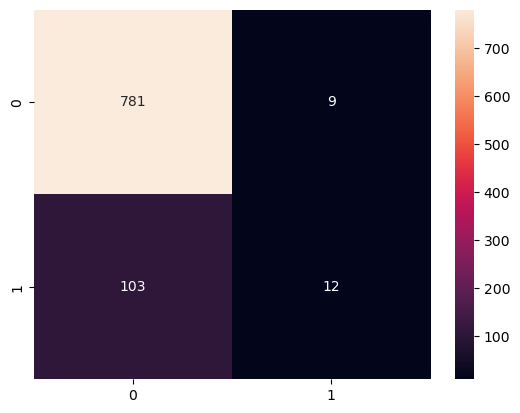

In [182]:
cmat_accuracy=confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

Y calculamos las métricas de clasificación.

In [184]:
print(f"Accuracy:{log_reg_best_model.score(X_train,Y_train):0.2%}")
print(f"Precision:{precision_score(Y_test,y_pred):0.2%}")
print(f"Recall:{recall_score(Y_test,y_pred):0.2%}")
print(f"F1:{f1_score(Y_test,y_pred):0.2%}")
log_reg_metrics = [log_reg_best_model.score(X_train,Y_train),precision_score(Y_test,y_pred),recall_score(Y_test,y_pred),f1_score(Y_test,y_pred)]

Accuracy:89.80%
Precision:57.14%
Recall:10.43%
F1:17.65%


Vemos que hay un buen Accuracy, sin embargo notamos también un Precision bien a secas y un Recall y F1 Score muy pobres. Ahora realizaremos la gráfica de la curva ROC.

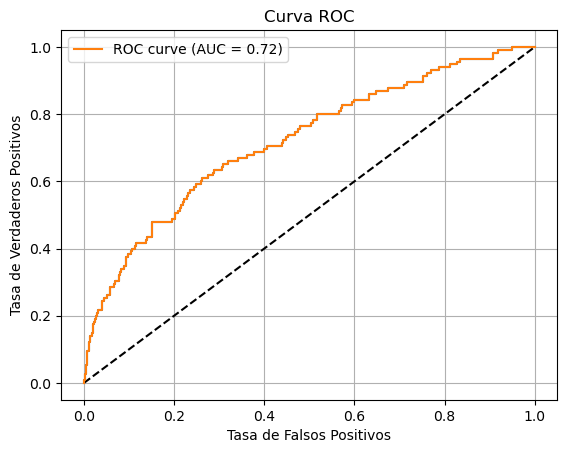

In [43]:
probs = log_reg_best_model.predict_proba(X_test)[:,1]

fpr,tpr,threshold=roc_curve(Y_test,probs)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle="--",color="k")
roc_auc = auc(fpr, tpr)

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.legend()
plt.grid(True)

Vemos que la curva pinta bien y el AUC es bueno. Ahora buscaremos el umbral óptimo que equlibre la tasa de verdaderos y falsos positivos.

In [45]:
J=tpr-fpr
ix=np.argmax(J)
best_threshold=threshold[ix]
best_threshold

0.12353422767372563

Y de acuerdo al estadístico de Jouden el umbral debe ser 0.12.

### Árboles de Decisión

In [190]:
from sklearn.tree import (DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz)

De manera muy similar al caso anterior, empezaremos por definir la partición del cunjunto de entrenamiento y prueba.

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

Creamos un diccionario con los posibles parámetros para definir el árbol de decisión.

In [51]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

Y mediante un GridSearch estos resultaron ser los mejores parámetros.

In [53]:
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 1) , param_grid = param_grid, cv = 10, scoring='accuracy')
grid_search.fit(X_train,Y_train)
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


Ajustamos el modelo con dichos parámetros y vemos de nuevo un buen score tanto en el conjunto de entrnamiento como el de prueba.

In [194]:
best_tree_clf = DecisionTreeClassifier(random_state = 1, min_samples_split = 2, max_depth = 3, criterion = 'entropy')

best_tree_clf.fit(X_train,Y_train)
y_pred = best_tree_clf.predict(X_test)
print("Accuracy en train,",best_tree_clf.score(X_train,Y_train))
print("Accuracy en test,",best_tree_clf.score(X_test,Y_test))

Accuracy en train, 0.8990597345132744
Accuracy en test, 0.876243093922652


Ahora para mejorar el modelo vamos a encontrar un valor óptimo para el parámetro de penalización alfa.

In [196]:
path = best_tree_clf.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00121187 0.00132737 0.00205634 0.00244393 0.00674505
 0.01116331 0.03578247]


In [63]:
models = []
for ccp_alpha in ccp_alphas:
    mod = DecisionTreeClassifier(ccp_alpha=ccp_alpha,random_state=0)
    mod.fit(X_train, Y_train)
    models.append(mod)
print("Numero de nodos en el ultimo arbol es: {} con ccp_alpha: {}".format(
      models[-1].tree_.node_count, ccp_alphas[-1]))
models

Numero de nodos en el ultimo arbol es: 3 con ccp_alpha: 0.011163306254732719


[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0012118655155118046, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.001327367802157248, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.002056336960767329, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.002443930071848746, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.006745045364755287, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.011163306254732719, random_state=0)]

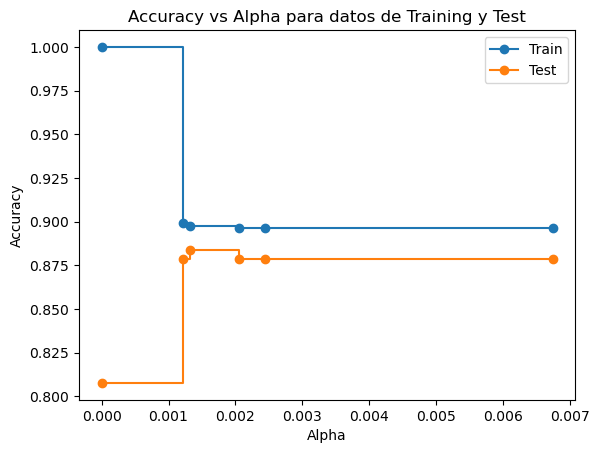

In [65]:
models = models[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [mod.score(X_train,Y_train) for mod in models]
test_scores = [mod.score(X_test, Y_test) for mod in models]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha para datos de Training y Test")
ax.plot(ccp_alphas, train_scores, marker='o', label="Train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="Test",
        drawstyle="steps-post")
ax.legend()
plt.show()

De acuerdo con el gráfico anterior el valor óptimo para alfa donde no hay una diferencia significativa en el Accuracy del conjunto de entrenamiento y de prueba corresponde al del tercer punto es decir el de valor 0.0013.

In [198]:
best_tree_clf = DecisionTreeClassifier(random_state = 1,ccp_alpha = 0.001327367802157248, min_samples_split = 2, max_depth = 3, criterion = 'entropy')

best_tree_clf.fit(X_train,Y_train)
y_pred = best_tree_clf.predict(X_test)
print("Accuracy en train,",best_tree_clf.score(X_train,Y_train))
print("Accuracy en test,",best_tree_clf.score(X_test,Y_test))

Accuracy en train, 0.8979535398230089
Accuracy en test, 0.8729281767955801


Realizamos la validación cruzada.

In [69]:
cvscore=cross_validate(best_tree_clf,X_train,Y_train,cv=10,scoring="accuracy")
cvscore["test_score"].mean()

0.8971227866117752

<Axes: >

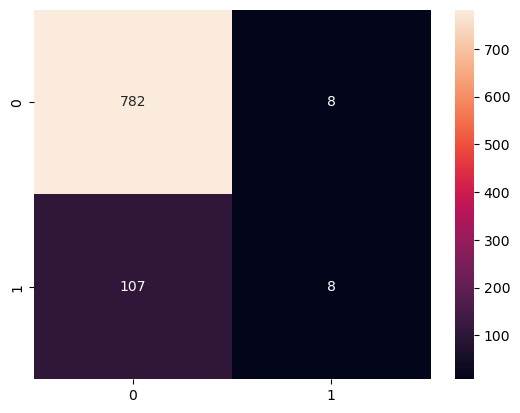

In [71]:
cmat_accuracy=confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

Calculamos las métricas y vemos un Accuracy bueno, en cambio un Recall bastante malo.

In [200]:
print(f"Accuracy:{best_tree_clf.score(X_train,Y_train):0.2%}")
print(f"Precision:{precision_score(Y_test,y_pred):0.2%}")
print(f"Recall:{recall_score(Y_test,y_pred):0.2%}")
print(f"F1:{f1_score(Y_test,y_pred):0.2%}")
tree_clf_metrics = [best_tree_clf.score(X_train,Y_train),precision_score(Y_test,y_pred),recall_score(Y_test,y_pred),f1_score(Y_test,y_pred)]

Accuracy:89.80%
Precision:50.00%
Recall:6.96%
F1:12.21%


Ahora procedemos a realizar la gráfica del árbol con los mejores parámetros. Notamos como la variable mpas importante (la del nodo raíz) es si la campaña de marketing anterior fue exitosa con el cliente.

[Text(0.5909090909090909, 0.875, 'poutcome_success <= 0.5\nentropy = 0.507\nsamples = 3616\nvalue = [3210, 406]\nclass = y[0]'),
 Text(0.36363636363636365, 0.625, 'contact_unknown <= 0.5\nentropy = 0.458\nsamples = 3514\nvalue = [3175, 339]\nclass = y[0]'),
 Text(0.18181818181818182, 0.375, 'age <= 1.828\nentropy = 0.527\nsamples = 2455\nvalue = [2162, 293]\nclass = y[0]'),
 Text(0.09090909090909091, 0.125, 'entropy = 0.502\nsamples = 2367\nvalue = [2105, 262]\nclass = y[0]'),
 Text(0.2727272727272727, 0.125, 'entropy = 0.936\nsamples = 88\nvalue = [57, 31]\nclass = y[0]'),
 Text(0.5454545454545454, 0.375, 'marital_married <= 0.5\nentropy = 0.258\nsamples = 1059\nvalue = [1013, 46]\nclass = y[0]'),
 Text(0.45454545454545453, 0.125, 'entropy = 0.384\nsamples = 360\nvalue = [333, 27]\nclass = y[0]'),
 Text(0.6363636363636364, 0.125, 'entropy = 0.18\nsamples = 699\nvalue = [680, 19]\nclass = y[0]'),
 Text(0.8181818181818182, 0.625, 'housing_no <= 0.5\nentropy = 0.928\nsamples = 102\nvalue

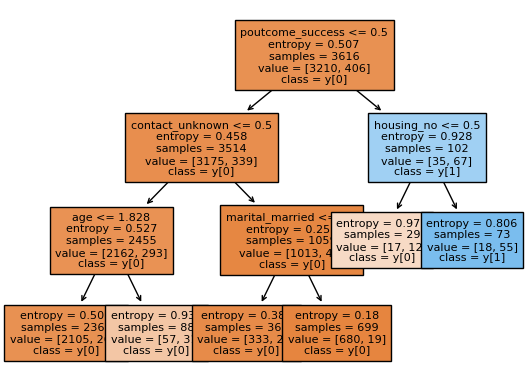

In [75]:
plot_tree(best_tree_clf.fit(X_train,Y_train), fontsize = 8, filled = True, class_names = True, feature_names = X_transformed.columns) 

## Support Vector Machines (Máquinas de Soporte Vectorial)

In [202]:
from sklearn.svm import SVC

A partir de este punto para los modelos siguientes el procedimiento es practicamente el mismo:

1. Particionar el conjunto de datos en entrenamiento y prueba.
2. Crear un diccionario de posibles parámetros para el modelo y mediante GridSearch seleccionar el mejor.
3. Ajustar el modelo con los mejores parámetros y calcular los scores de entrenamiento y prueba.
4. Crear la matriz de confusión con las predicciones hechas por el modelo y los datos reales.
5. Calcular las métricas de desempeño (Accuracy, Precision, Recall y F1-Score).

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

In [206]:
model_params={
    "tree_model":{
        "model":SVC(), 
        "params":{
            "C":[.001,.01,.1,1,10],
            "kernel":["linear", "poly", "rbf","sigmoid"],
            'gamma': ['scale', 'auto']
        }
    }
}

In [83]:
start_time = time.time()
r2_models=[]
for model_name,mp in model_params.items():
    modelo=GridSearchCV(mp["model"],mp["params"],cv=3,n_jobs=-1,scoring="r2",verbose=0)
    modelo.fit(X_train,Y_train)
    r2_models.append({
        "model":model_name,
        "best_score":modelo.best_score_,
        "best_params":modelo.best_params_
    })
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.175138711929321 seconds ---


In [85]:
df_r2_models = pd.DataFrame(r2_models).sort_values(by = "best_score", ascending = False)
df_r2_models

,model,best_score,best_params
0,tree_model,-0.037735,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"


In [208]:
best_svc_model = SVC(C=10,kernel="rbf",gamma="auto").fit(X_train,Y_train)
print("SVC_model R2 en train,",best_svc_model.score(X_train,Y_train))
print("SVC_model R2 en test,",best_svc_model.score(X_test,Y_test)) 
y_pred = best_svc_model.predict(X_test)

SVC_model R2 en train, 0.900995575221239
SVC_model R2 en test, 0.8806629834254144


In [210]:
cvscore = cross_validate(best_svc_model,X_train,Y_train,cv=10, scoring = "accuracy")
cvscore["test_score"].mean()

0.8971220213954485

<Axes: >

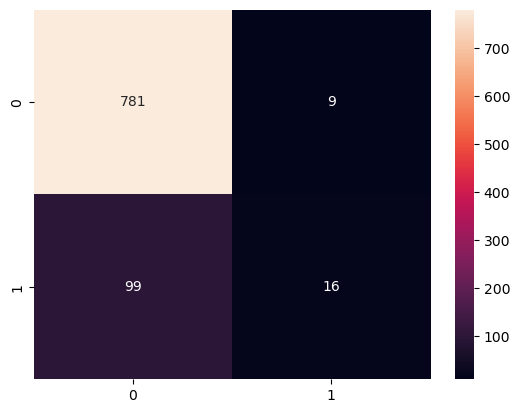

In [91]:
cmat_accuracy = confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

In [212]:
print(f"Accuracy: {best_svc_model.score(X_train,Y_train):0.2%}")
print(f"Precision: {precision_score(Y_test,y_pred):0.2%}")
print(f"Recall: {recall_score(Y_test,y_pred):0.2%}")
print(f"F1: {f1_score(Y_test,y_pred):0.2%}")
svc_metrics = [best_svc_model.score(X_train,Y_train),precision_score(Y_test,y_pred),recall_score(Y_test,y_pred),f1_score(Y_test,y_pred)]

Accuracy: 90.10%
Precision: 64.00%
Recall: 13.91%
F1: 22.86%


## Bagging - Boosting

In [214]:
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestRegressor,RandomForestClassifier
from xgboost import  XGBClassifier,XGBRegressor

In [216]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

In [105]:
model_params={
    
    "forest_model":{
        "model":RandomForestClassifier(), 
        "params":{
            "n_estimators":[10,100,500],
            "max_depth":[4,8,15],

            "criterion":["gini","entropy"],
            "random_state":[0,42]
        }
    },
    "ada_model":{
        "model":AdaBoostClassifier(), 
        "params":{
            "n_estimators":[10,100,500],
            "random_state":[0,42],
            "learning_rate":[.01,1,.001]
        }
    },
    "xgb_model":{
        "model":XGBClassifier(), 
        "params":{
            "n_estimators":[10,100,500],
            "learning_rate":[.01,1,.001]
        }
    },
                
}

In [107]:
accuracy_models=[]
for model_name,mp in model_params.items():

    modelo=GridSearchCV(mp["model"],mp["params"],cv=5,n_jobs=-1,scoring="accuracy",verbose=0)
    
    modelo.fit(X_train,Y_train)
    accuracy_models.append({
        "model":model_name,
        "best_score":modelo.best_score_,
        "best_params":modelo.best_params_
    })

In [109]:
df_accuracy_models=pd.DataFrame(accuracy_models).sort_values(by="best_score",ascending=False)
df_accuracy_models

,model,best_score,best_params
0,forest_model,0.896849,"{'criterion': 'entropy', 'max_depth': 8, 'n_es..."
1,ada_model,0.896573,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
2,xgb_model,0.895743,"{'learning_rate': 0.01, 'n_estimators': 500}"


In [111]:
df_accuracy_models.head(1).best_params.values

array([{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100, 'random_state': 0}],
      dtype=object)

In [218]:
forest_model = RandomForestClassifier(random_state = 0, n_estimators = 100, criterion = "entropy", max_depth = 8, oob_score = True).fit(X_train,Y_train)
y_pred =  forest_model.predict(X_test)
print("Forest Model accuracy en train,",forest_model.score(X_train,Y_train))
print("Forest Model accuracy en test,",forest_model.score(X_test,Y_test)) 

Forest Model accuracy en train, 0.9070796460176991
Forest Model accuracy en test, 0.8740331491712707


In [220]:
cvscore = cross_validate(forest_model,X_train,Y_train,cv=10, scoring = "accuracy")
cvscore["test_score"].mean()

0.8968473087341792

<Axes: >

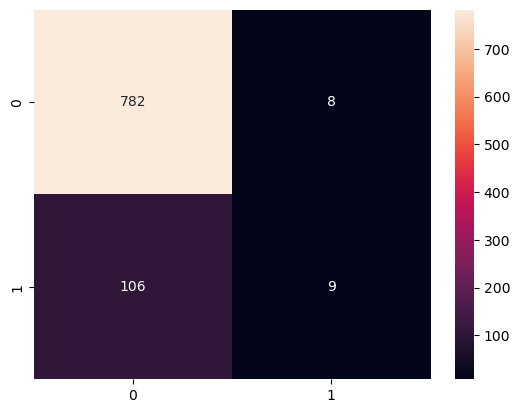

In [119]:
cmat_accuracy=confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

In [222]:
print(f"Accuracy: {forest_model.score(X_train,Y_train):0.2%}")
print(f"Precision: {precision_score(Y_test,y_pred):0.2%}")
print(f"Recall: {recall_score(Y_test,y_pred):0.2%}")
print(f"F1: {f1_score(Y_test,y_pred):0.2%}")
forest_metrics = [forest_model.score(X_train,Y_train),precision_score(Y_test,y_pred),recall_score(Y_test,y_pred),f1_score(Y_test,y_pred)]

Accuracy: 90.71%
Precision: 52.94%
Recall: 7.83%
F1: 13.64%


## K Nearest Neighbours (KNN)

In [226]:
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier

In [228]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

In [230]:
model_params={
    "knn_model":{
        "model":KNeighborsClassifier(), 
        "params":{ "n_neighbors":list(range(1,12)),
                   "metric": ['minkowski','euclidean','haversine','manhattan']
        }
    }
}

In [232]:
models=[]
for model_name,mp in model_params.items():

    modelo=GridSearchCV(mp["model"],mp["params"],cv=5,n_jobs=-1,scoring="accuracy",verbose=0)
    
    modelo.fit(X_train,Y_train)
    models.append({
        "model":model_name,
        "best_score":modelo.best_score_,
        "best_params":modelo.best_params_
    })

In [142]:
df_models=pd.DataFrame(models).sort_values(by="best_score",ascending=False)
df_models

,model,best_score,best_params
0,knn_model,0.891317,"{'metric': 'minkowski', 'n_neighbors': 11}"


In [234]:
knn_model = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski').fit(X_train,Y_train)
y_pred =  knn_model.predict(X_test)
print("knn_model accuracy en train,",knn_model.score(X_train,Y_train))
print("knn_model accuracy en test,",knn_model.score(X_test,Y_test)) 

knn_model accuracy en train, 0.8962942477876106
knn_model accuracy en test, 0.8740331491712707


In [236]:
cvscore = cross_validate(knn_model,X_train,Y_train,cv=10, scoring = "accuracy")
cvscore["test_score"].mean()

0.8902128831820756

<Axes: >

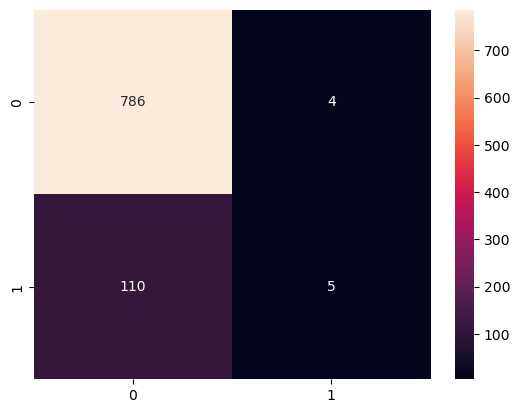

In [162]:
cmat_accuracy=confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

In [242]:
print(f"Accuracy: {knn_model.score(X_train,Y_train):0.2%}")
print(f"Precision: {precision_score(Y_test,y_pred):0.2%}")
print(f"Recall: {recall_score(Y_test,y_pred):0.2%}")
print(f"F1: {f1_score(Y_test,y_pred):0.2%}")
knn_metrics = [knn_model.score(X_train,Y_train),precision_score(Y_test,y_pred),recall_score(Y_test,y_pred),f1_score(Y_test,y_pred)]

Accuracy: 89.63%
Precision: 55.56%
Recall: 4.35%
F1: 8.06%


## Selección del mejor modelo

Ahora, para seleccionar al mejor modelo tomamos en cuenta las métricas de desempeño. En todos los casos notamos un patrón similar: Hay un muy buen Accuracy, seguido por un Precision apenas pasable y un Recall y F1-Score mediocres. Lo anterior deriva del hecho de que en este problema de clasificación existe un claro desbalance en las clases, por lo que confiar ciegamente en el Accuracy puede ser engañoso. Sin embargo, dado que consideramos que el mejor modelo es aquel que puede predecir correctamente a aquellos clientes que SI harán un depósito, nos iremos por aquel con mayor Recall. Que en su caso es el modelo de **Suport Vector Machines (SVM)** es decir el best_svc_model.

In [250]:
print(['Accuracy','Precision','Recall','F1-Score'])
print(log_reg_metrics)
print(tree_clf_metrics)
print(svc_metrics)
print(forest_metrics)
print(knn_metrics)

['Accuracy', 'Precision', 'Recall', 'F1-Score']
[0.8979535398230089, 0.5714285714285714, 0.10434782608695652, 0.17647058823529413]
[0.8979535398230089, 0.5, 0.06956521739130435, 0.12213740458015267]
[0.900995575221239, 0.64, 0.1391304347826087, 0.22857142857142856]
[0.9070796460176991, 0.5294117647058824, 0.0782608695652174, 0.13636363636363635]
[0.8962942477876106, 0.5555555555555556, 0.043478260869565216, 0.08064516129032258]


## Datos Desbalanceados

Para lidiar con el problema del desbalance de clases, después de prueba y error, de todas las técnicas conocidas (RandomUnderSampler, RandomOverSampler, SMOTE, Borderline SMOTE y ADASYN) aquella que dio el mejor resultado (hablando relativamente) fue **SMOTE**. Así, procedemos a ajustar el modelo de SVM con la técnica SMOTE.

In [379]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 1)

best_svc_model = SVC(C=10,kernel="rbf",gamma="auto").fit(X_train,Y_train)
print("SVC_model R2 en train,",best_svc_model.score(X_train,Y_train))
print("SVC_model R2 en test,",best_svc_model.score(X_test,Y_test)) 
y_pred = best_svc_model.predict(X_test)

SVC_model R2 en train, 0.900995575221239
SVC_model R2 en test, 0.8806629834254144


In [306]:
from imblearn.over_sampling import SMOTE

In [386]:
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed,Y, test_size = 0.2, random_state = 1)
smote = SMOTE(random_state=0)

X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

svc_smote = SVC(C=10,kernel="rbf",gamma="auto").fit(X_train_smote,Y_train_smote)
svc_smote.fit(X_train_smote, Y_train_smote)
print("SVC Model accuracy en train,",svc_smote.score(X_train_smote,Y_train_smote))
print("SVC Model accuracy en test,",svc_smote.score(X_test,Y_test))

SVC Model accuracy en train, 0.8820872274143302
SVC Model accuracy en test, 0.8276243093922652


<Axes: >

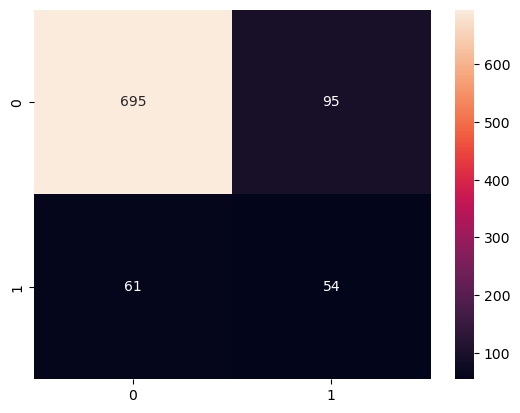

In [388]:
y_pred =  svc_smote.predict(X_test)
cmat_accuracy=confusion_matrix(Y_test,y_pred)
sns.heatmap(cmat_accuracy,annot=True,fmt=",")

In [390]:
print(f"Accuracy: {svc_smote.score(X_train,Y_train):0.2%}")
print(f"Precision: {precision_score(Y_test,y_pred):0.2%}")
print(f"Recall: {recall_score(Y_test,y_pred):0.2%}")
print(f"F1: {f1_score(Y_test,y_pred):0.2%}")

Accuracy: 87.69%
Precision: 36.24%
Recall: 46.96%
F1: 40.91%


Y notamos en primera instancia una mejora en el número de verdaderos positivos, 54 contra 16 ; un Recall de 46.96% contra 13.91%, lo que equivale a una mejora de 33% y por último una mejora en el F1-Score de 18%. Claro, todo esto a un costo, que es el de un menor Accuracy y Precision. Finalmente con todos los modelos realizados, las métricas para medir el desempeño, las mejoras hechas y todas las consideraciones se opta por recomendar el modelo de SVM. Además de lo anteriormente expuesto es evidente que para los casos donde exista un problema de clases desbalanceadas es necesario y más que recomendable el uso de técnicas de aumento de datos para poder llevar el rendimiento del modelo a otro nivel. Esto dado que los modelos de SVM no son precisamente los mejores para problemas de clasificación binaria, sin embargo en este caso resulto ser el mejor debido a la presencia del desbalance y una vez implemtado se logró un mejor resultado.